<a href="https://colab.research.google.com/github/anas-awadalla/Autonomous-Driving-Deep-Neural-Network/blob/master/Autonomus_Driving_Model_Using_AirSim_Data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Goal: Train a convolutional neural network that can makes steering angle predictions based on camera images of the
vehicle's state

STEP 1: Explore and Prep Data

In [0]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import random

RAW_DATA_DIR = '/content/drive/My Drive/data_raw/'
COOKED_DATA_DIR = 'data_cooked/'
DATA_FOLDERS = ['normal_1', 'normal_2', 'normal_3', 'normal_4', 'normal_5', 'normal_6', 'swerve_1', 'swerve_2', 'swerve_3']
FIGURE_SIZE = (10,10)

In [32]:
sample_tsv_path = os.path.join(RAW_DATA_DIR, 'normal_1/airsim_rec.txt')
sample_tsv = pd.read_csv(sample_tsv_path, sep='\t')
sample_tsv.head()

,Timestamp,Speed (kmph),Throttle,Steering,Brake,Gear,ImageName
0,93683464,0,0.0,0.000000,0.0,N,img_0.png
1,93689595,0,0.0,0.000000,0.0,N,img_1.png
2,93689624,0,0.0,-0.035522,0.0,N,img_2.png
3,93689624,0,0.0,-0.035522,0.0,N,img_3.png
4,93689624,0,0.0,-0.035522,0.0,N,img_4.png


In [33]:
#Putting all the data togther (non image data)
full_path_raw_folders = [os.path.join(RAW_DATA_DIR, f) for f in DATA_FOLDERS]

dataframes = []
for folder in full_path_raw_folders:
    current_dataframe = pd.read_csv(os.path.join(folder, 'airsim_rec.txt'), sep='\t')
    current_dataframe['Folder'] = folder
    dataframes.append(current_dataframe)
    
dataset = pd.concat(dataframes, axis=0)

print('Number of data points: {0}'.format(dataset.shape[0]))

dataset.head()

Number of data points: 46738


,Timestamp,Speed (kmph),Throttle,Steering,Brake,Gear,ImageName,Folder
0,93683464,0,0.0,0.000000,0.0,N,img_0.png,/content/drive/My Drive/data_raw/normal_1
1,93689595,0,0.0,0.000000,0.0,N,img_1.png,/content/drive/My Drive/data_raw/normal_1
2,93689624,0,0.0,-0.035522,0.0,N,img_2.png,/content/drive/My Drive/data_raw/normal_1
3,93689624,0,0.0,-0.035522,0.0,N,img_3.png,/content/drive/My Drive/data_raw/normal_1
4,93689624,0,0.0,-0.035522,0.0,N,img_4.png,/content/drive/My Drive/data_raw/normal_1


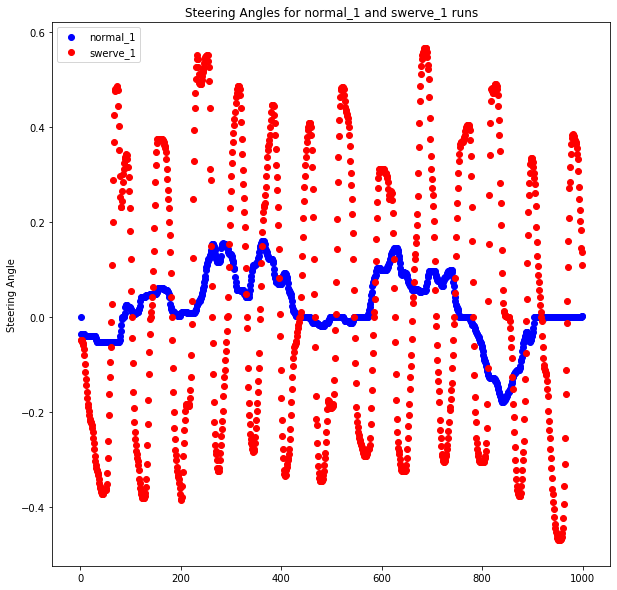

In [34]:
#NORMAL VS SWERVE CONDITIONS DATA COMPARISIONS
steering_angles_normal_1 = dataset[dataset['Folder'].apply(lambda v: 'normal_1' in v)]['Steering'][1:1000]
steering_angles_swerve_1 = dataset[dataset['Folder'].apply(lambda v: 'swerve_1' in v)]['Steering'][1:1000]
plot_index = [i for i in range(1, 1000, 1)]
fig = plt.figure(figsize=FIGURE_SIZE)
ax1 = fig.add_subplot(111)
ax1.scatter(plot_index, steering_angles_normal_1, c='b', marker='o', label='normal_1')
ax1.scatter(plot_index, steering_angles_swerve_1, c='r', marker='o', label='swerve_1')
plt.legend(loc='upper left');
plt.title('Steering Angles for normal_1 and swerve_1 runs')
plt.ylabel('Steering Angle')
plt.show()

In [39]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
import keras.backend as K
from keras.preprocessing import image
!pip install keras_tqdm
from keras_tqdm import TQDMNotebookCallback

import json
import os
import numpy as np
import pandas as pd
from Generator import DriveDataGenerator
import Cooking
import h5py
from PIL import Image, ImageDraw
import math
import matplotlib.pyplot as plt

COOKED_DATA_DIR = 'data_cooked/'
MODEL_OUTPUT_DIR = 'model'

In [0]:
train_eval_test_split = [0.7, 0.2, 0.1]
full_path_raw_folders = [os.path.join(RAW_DATA_DIR, f) for f in DATA_FOLDERS]
Cooking.cook(full_path_raw_folders, COOKED_DATA_DIR, train_eval_test_split)

Reading data from /content/drive/My Drive/data_raw/normal_1...
Reading data from /content/drive/My Drive/data_raw/normal_2...
Reading data from /content/drive/My Drive/data_raw/normal_3...
Reading data from /content/drive/My Drive/data_raw/normal_4...
Reading data from /content/drive/My Drive/data_raw/normal_5...
Reading data from /content/drive/My Drive/data_raw/normal_6...
Reading data from /content/drive/My Drive/data_raw/swerve_1...
Reading data from /content/drive/My Drive/data_raw/swerve_2...
Reading data from /content/drive/My Drive/data_raw/swerve_3...
Processing data_cooked/train.h5...


In [0]:
train_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'train.h5'), 'r')
eval_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'eval.h5'), 'r')
test_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'test.h5'), 'r')
num_train_examples = train_dataset['image'].shape[0]
num_eval_examples = eval_dataset['image'].shape[0]
num_test_examples = test_dataset['image'].shape[0]
batch_size=32

In [38]:
data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=True, brighten_range=0.4)
train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[76,135,0,255])
eval_generator = data_generator.flow\
    (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[76,135,0,255])

ValueError: ignored

In [0]:
image_input_shape = sample_batch_train_data[0].shape[1:]
state_input_shape = sample_batch_train_data[1].shape[1:]
activation = 'relu'
pic_input = Input(shape=image_input_shape)
img_stack = Conv2D(16, (3, 3), name="convolution0", padding='same', activation=activation)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)
state_input = Input(shape=state_input_shape)
merged = concatenate([img_stack, state_input])
merged = Dense(64, activation=activation, name='dense0')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10, activation=activation, name='dense2')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1, name='output')(merged)
adam = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=[pic_input, state_input], outputs=merged)
model.compile(optimizer=adam, loss='mse')

In [0]:
model.summary()


In [0]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback, TQDMNotebookCallback()]

In [0]:
history = model.fit_generator(train_generator, steps_per_epoch=num_train_examples//batch_size, epochs=500, callbacks=callbacks,\
                   validation_data=eval_generator, validation_steps=num_eval_examples//batch_size, verbose=2

In [0]:
[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
predictions = model.predict([sample_batch_train_data[0], sample_batch_train_data[1]])
for i in range(0, 3, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i], predictions[i])